# Установка зависимостей и библиотек

In [ ]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install networkx
!pip install matplotlib seaborn

# Подключение библиотек и датасетов

In [ ]:
import torch
import networkx as nx
from torch_geometric.datasets import Planetoid, OGB_MAG, PPI
from torch_geometric.utils import to_networkx

# Загружаем датасеты
def load_cora():
    return Planetoid(root='./data/Cora', name='Cora')[0]

def load_pubmed():
    return Planetoid(root='./data/PubMed', name='PubMed')[0]


cora_graph = load_cora()
pubmed_graph = load_pubmed()

Processing...
Done!
Processing...
Done!


# Загрузка пакета SDV

In [ ]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.3/154.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.4 MB/s eta 0:00:00


# Подготовка данных под работу с sdv.multi_tables

## Извлечение и подготовка таблиц узлов и ребер

In [ ]:
import pandas as pd

# Получение данных узлов
node_ids = range(cora_graph.num_nodes)
node_features = cora_graph.x.numpy()  # Признаки узлов
node_labels = cora_graph.y.numpy()    # Метки классов узлов
nodes_df = pd.DataFrame(node_features, columns=[f'feature_{i}' for i in range(node_features.shape[1])])
nodes_df['node_id'] = node_ids
nodes_df['label'] = node_labels

# Получение данных ребер
edge_index = cora_graph.edge_index.numpy()
edges_df = pd.DataFrame({'source': edge_index[0], 'target': edge_index[1]})


In [ ]:
nodes_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1425,feature_1426,feature_1427,feature_1428,feature_1429,feature_1430,feature_1431,feature_1432,node_id,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,3


In [ ]:
edges_df.head()

,source,target
0,633,0
1,1862,0
2,2582,0
3,2,1
4,652,1


## Определение схемы данных для SDV

In [ ]:
from sdv.multi_table import HMASynthesizer
from sdv.metadata import Metadata

# Определение связей между таблицами
metadata = Metadata.detect_from_dataframes(
    data={
        'nodes': nodes_df,
        'edges': edges_df
    })


In [ ]:
metadata

{
    "tables": {
        "nodes": {
            "primary_key": "node_id",
            "columns": {
                "feature_0": {
                    "sdtype": "categorical"
                },
                "feature_1": {
                    "sdtype": "categorical"
                },
                "feature_2": {
                    "sdtype": "categorical"
                },
                "feature_3": {
                    "sdtype": "categorical"
                },
                "feature_4": {
                    "sdtype": "categorical"
                },
                "feature_5": {
                    "sdtype": "categorical"
                },
                "feature_6": {
                    "sdtype": "categorical"
                },
                "feature_7": {
                    "sdtype": "categorical"
                },
                "feature_8": {
                    "sdtype": "categorical"
                },
                "feature_9": {
                    "sd

## Обучение модели (время ~ 10 мин)

In [ ]:
data_dict = {'nodes': nodes_df, 'edges': edges_df}

synthesizer = HMASynthesizer(metadata)
synthesizer.fit(data_dict)

/usr/local/lib/python3.10/dist-packages/sdv/multi_table/base.py:102: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


PerformanceAlert: Using the HMASynthesizer on this metadata schema is not recommended. To model this data, HMA will generate a large number of columns. (1436 columns)


Table Name  # Columns in Metadata  Est # Columns
     nodes                   1434           1434
     edges                      2              2

We recommend simplifying your metadata schema using 'sdv.utils.poc.simplify_schema'.
If this is not possible, contact us at info@sdv.dev for enterprise solutions.



Preprocess Tables: 100%|██████████| 2/2 [02:53<00:00, 86.56s/it] 



Learning relationships:



Modeling Tables: 100%|██████████| 2/2 [02:53<00:00, 86.57s/it]


## Метод Генерации Синтетики ([источник](https://docs.sdv.dev/sdv/multi-table-data/sampling))

In [ ]:
def get_synthetic_data(synthsizer_obj: HMASynthesizer, scale: float = 1.0) -> dict:
  """
  :param synthsizer_obj: HMASynthesizer trained model
  :type synthsizer_obj: HMASynthesizer
  :param scale: A float > 0.0 that describes how much to scale the data by
  :type scale: float
  """
  synthetic_data = synthsizer_obj.sample(scale=scale)
  return synthetic_data

### Тест метода Генерации Синтетики

In [ ]:
synthetic_data = get_synthetic_data(synthesizer)

In [ ]:
synthetic_data.keys()

dict_keys(['nodes', 'edges'])

In [ ]:
synthetic_data["nodes"].shape

(2708, 1435)

In [ ]:
synthetic_data["edges"].shape

(10556, 2)

## Методы сохранения и загрузки Синтетики

In [ ]:
from datetime import datetime

def save_synthetic_model(synthsizer_obj: HMASynthesizer, model_name: str = "") -> str:
  filename = model_name
  if not filename:
    filename = f"model_hmasynth_{datetime.now()}"

  filepath = f"{filename}.pkl"
  synthesizer.save(
    filepath=filepath)

  return filepath

def load_synthetic_model(filepath: str) -> HMASynthesizer | None:
  try:
    synthesizer = HMASynthesizer.load(filepath=filepath)
    return synthesizer
  except Exception as err:
    print(f"Во время загрузки произошла ошибка: {str(err)}")
    return

### Тест методов сохранения и загрузки

In [ ]:
filepath_to_synth_obj = save_synthetic_model(synthesizer)
filepath_to_synth_obj

'model_hmasynth_2024-11-12 13:14:57.951110.pkl'

In [ ]:
saved_synth_obj = load_synthetic_model(filepath_to_synth_obj)
saved_synth_obj

## Трансформация таблиц в граф

In [ ]:
synthetic_nodes = synthetic_data['nodes']
synthetic_edges = synthetic_data['edges']

In [ ]:
import torch
from torch_geometric.data import Data

def transform_synth_data_to_graph(synthetic_data: dict) -> Data:
  try:
    # Извлечение данных узлов и ребер из синтетических таблиц
    synthetic_nodes, synthetic_edges = synthetic_data['nodes'], synthetic_data['edges']

    # Признаки узлов
    node_features = torch.tensor(synthetic_nodes[[col for col in synthetic_nodes.columns if 'feature_' in col]].values, dtype=torch.float)
    # Метки классов узлов
    node_labels = torch.tensor(synthetic_nodes['label'].values, dtype=torch.long)

    # Источники и цели для ребер
    edge_sources = torch.tensor(synthetic_edges['source'].values, dtype=torch.long)
    edge_targets = torch.tensor(synthetic_edges['target'].values, dtype=torch.long)
    edge_index = torch.stack([edge_sources, edge_targets], dim=0)  # Ребра для графа

    # Создание графа
    synthetic_graph = Data(x=node_features, edge_index=edge_index, y=node_labels)
    return synthetic_graph
  except Exception as err:
    print(f"Во время трансформации произошла ошибка: {str(err)}")
    return Data()



### Проверка метода Трансформации таблиц в граф

In [ ]:
synthetic_graph = transform_synth_data_to_graph(synthetic_data)

if synthetic_graph.get("x", None) is not None:
  print(synthetic_graph.x.shape)
else:
  print("Трансформация вернула пустой объект")

torch.Size([2708, 1433])


# Сравнение метрик исходного с синтетическим

## Кастомные метрики

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx
from networkx.algorithms.cluster import clustering
from networkx.algorithms.centrality import degree_centrality, closeness_centrality, betweenness_centrality, eigenvector_centrality
from networkx.algorithms.smallworld import sigma

def compute_metrics(graph_data, to_undirected=True):
    """ Функция для вычисления характеристик графа"""
    # Конвертируем граф в формат NetworkX
    G = to_networkx(graph_data, to_undirected=to_undirected)

    # Степень вершины
    try:
      degree_dict = dict(G.degree())
      print(f"Degree: {degree_dict}")
    except Exception as err:
      print(f"Degree error: {str(err)}")
      degree_dict = None

    # Диаметр графа
    if to_undirected:
      diameter = nx.diameter(G) if nx.is_connected(G) else None
      print(f"Diameter: {diameter}")
    else:
      diameter = None
      print(f"Diameter not supported for directed graphs")


    # Кластерный коэффициент для вершин
    try:
      clustering_coeff = clustering(G)
      print(f"Clustering Coefficient: {clustering_coeff}")
    except Exception as err:
      print(f"Clustering Coefficient error: {str(err)}")
      clustering_coeff = None


    # Центральность по степени
    try:
      degree_cent = degree_centrality(G)
      print(f"Degree Centrality: {degree_cent}")
    except Exception as err:
      print(f"Degree Centrality error: {str(err)}")
      degree_cent = None


    # Центральность по близости
    try:
      closeness_cent = closeness_centrality(G)
      print(f"Closeness Centrality: {closeness_cent}")
    except Exception as err:
      print(f"Closeness Centrality error: {str(err)}")
      closeness_cent = None


    # Междуузловая центральность
    try:
      betweenness_cent = betweenness_centrality(G)
      print(f"Betweenness Centrality: {betweenness_cent}")
    except Exception as err:
      print(f"Betweenness Centrality error: {str(err)}")
      betweenness_cent = None


    # Собственная центральность
    try:
      eigenvector_cent = eigenvector_centrality(G)
      print(f"Eigenvector Centrality: {eigenvector_cent}")
    except Exception as err:
      print(f"Eigenvector Centrality error: {str(err)}")
      eigenvector_cent = None

    # Эксцентриситет
    try:
      eccentricity = dict(nx.eccentricity(G))
      print(f"Eccentricity: {eccentricity}")
    except Exception as err:
      print(f"Eccentricity error: {str(err)}")
      eccentricity = None


    # Количество треугольников
    try:
      triangles = nx.triangles(G)
      print(f"Triangle Count: {triangles}")
    except Exception as err:
      print(f"Triangle Count error: {str(err)}")
      triangles = None


    return {
        "degree": degree_dict,
        "diameter": diameter,
        "clustering_coeff": clustering_coeff,
        "degree_cent": degree_cent,
        "closeness_cent": closeness_cent,
        "betweenness_cent": betweenness_cent,
        "eigenvector_cent": eigenvector_cent,
        "eccentricity": eccentricity,
        "triangles": triangles
    }

In [ ]:
print("CoraML Metrics")
cora_metrics = compute_metrics(cora_graph)

CoraML Metrics
Degree: {0: 3, 1: 3, 2: 5, 3: 1, 4: 5, 5: 3, 6: 4, 7: 1, 8: 3, 9: 2, 10: 2, 11: 2, 12: 4, 13: 2, 14: 5, 15: 4, 16: 4, 17: 5, 18: 5, 19: 1, 20: 5, 21: 2, 22: 5, 23: 1, 24: 7, 25: 4, 26: 5, 27: 4, 28: 1, 29: 2, 30: 6, 31: 1, 32: 4, 33: 9, 34: 1, 35: 3, 36: 8, 37: 3, 38: 4, 39: 7, 40: 3, 41: 4, 42: 2, 43: 6, 44: 3, 45: 6, 46: 2, 47: 2, 48: 9, 49: 2, 50: 1, 51: 6, 52: 5, 53: 3, 54: 2, 55: 12, 56: 4, 57: 1, 58: 1, 59: 10, 60: 3, 61: 5, 62: 1, 63: 1, 64: 3, 65: 10, 66: 1, 67: 3, 68: 3, 69: 7, 70: 2, 71: 3, 72: 2, 73: 12, 74: 9, 75: 6, 76: 3, 77: 2, 78: 3, 79: 2, 80: 3, 81: 4, 82: 2, 83: 2, 84: 5, 85: 3, 86: 4, 87: 3, 88: 36, 89: 10, 90: 4, 91: 6, 92: 2, 93: 4, 94: 11, 95: 21, 96: 1, 97: 2, 98: 1, 99: 6, 100: 2, 101: 3, 102: 8, 103: 6, 104: 4, 105: 4, 106: 1, 107: 4, 108: 3, 109: 32, 110: 5, 111: 6, 112: 4, 113: 3, 114: 3, 115: 1, 116: 2, 117: 2, 118: 19, 119: 6, 120: 5, 121: 7, 122: 4, 123: 4, 124: 5, 125: 2, 126: 6, 127: 1, 128: 4, 129: 2, 130: 3, 131: 2, 132: 5, 133: 9, 134:

In [ ]:
print("CoraML Synthetic Metrics")
cora_synth_metrics = compute_metrics(synthetic_graph)

CoraML Synthetic Metrics
Degree: {0: 3, 1: 6, 2: 5, 3: 6, 4: 4, 5: 8, 6: 3, 7: 10, 8: 7, 9: 7, 10: 2, 11: 5, 12: 4, 13: 4, 14: 8, 15: 7, 16: 7, 17: 2, 18: 7, 19: 8, 20: 8, 21: 12, 22: 7, 23: 5, 24: 5, 25: 5, 26: 6, 27: 5, 28: 11, 29: 4, 30: 6, 31: 5, 32: 7, 33: 8, 34: 6, 35: 6, 36: 6, 37: 6, 38: 5, 39: 3, 40: 8, 41: 5, 42: 4, 43: 8, 44: 8, 45: 16, 46: 6, 47: 7, 48: 9, 49: 8, 50: 7, 51: 6, 52: 11, 53: 11, 54: 10, 55: 6, 56: 13, 57: 8, 58: 7, 59: 14, 60: 7, 61: 6, 62: 7, 63: 9, 64: 8, 65: 7, 66: 7, 67: 5, 68: 9, 69: 3, 70: 10, 71: 5, 72: 9, 73: 10, 74: 6, 75: 6, 76: 7, 77: 12, 78: 7, 79: 8, 80: 8, 81: 8, 82: 11, 83: 11, 84: 8, 85: 3, 86: 7, 87: 6, 88: 5, 89: 9, 90: 6, 91: 8, 92: 3, 93: 7, 94: 6, 95: 8, 96: 5, 97: 7, 98: 12, 99: 7, 100: 13, 101: 8, 102: 9, 103: 8, 104: 8, 105: 8, 106: 9, 107: 9, 108: 4, 109: 7, 110: 5, 111: 10, 112: 6, 113: 10, 114: 7, 115: 8, 116: 10, 117: 8, 118: 11, 119: 5, 120: 4, 121: 5, 122: 11, 123: 13, 124: 11, 125: 7, 126: 11, 127: 8, 128: 8, 129: 9, 130: 5, 131:

## Метрики из SDV: SDMetrics ([источник](https://docs.sdv.dev/sdmetrics/reports/diagnostic-report/multi-table-api))

### Генерация отчета

In [ ]:
!pip install sdmetrics

In [ ]:
from sdmetrics.reports.multi_table import DiagnosticReport

metadata_dict = metadata.to_dict()
real_data = {'nodes': nodes_df, 'edges': edges_df}

report = DiagnosticReport()
report.generate(real_data, synthetic_data, metadata_dict)

Generating report ...

(1/3) Evaluating Data Validity: |██████████| 1437/1437 [00:00<00:00, 1875.79it/s]|
Data Validity Score: 100.0%

(2/3) Evaluating Data Structure: |██████████| 2/2 [00:00<00:00, 66.34it/s]|
Data Structure Score: 100.0%

(3/3) Evaluating Relationship Validity: |          | 0/0 [00:00<?, ?it/s]|
Relationship Validity Score: nan%

Overall Score (Average): 100.0%



### Объяснение результата отчета( [как формируется оценка](https://github.com/sdv-dev/SDMetrics/blob/main/sdmetrics/reports/multi_table/_properties/relationship_validity.py))

In [ ]:
report.get_properties()

,Property,Score
0,Data Validity,1.0
1,Data Structure,1.0
2,Relationship Validity,NaN


In [ ]:
report.get_details(
    property_name='Data Validity'
)

,Table,Column,Metric,Score
0,nodes,feature_0,CategoryAdherence,1.0
1,nodes,feature_1,CategoryAdherence,1.0
2,nodes,feature_2,CategoryAdherence,1.0
3,nodes,feature_3,CategoryAdherence,1.0
4,nodes,feature_4,CategoryAdherence,1.0
...,...,...,...,...
1432,nodes,feature_1432,CategoryAdherence,1.0
1433,nodes,node_id,KeyUniqueness,1.0
1434,nodes,label,CategoryAdherence,1.0
1435,edges,source,BoundaryAdherence,1.0


In [ ]:
report.get_details(
    property_name='Data Structure',
    table_name='nodes'
)

,Table,Metric,Score
0,nodes,TableStructure,1.0


In [ ]:
fig = report.get_visualization(
    property_name='Data Validity',
    table_name='nodes'
)
fig.show()

### Сохранение и загрузка отчета

In [ ]:
def save_report(report: DiagnosticReport, report_name: str = "") -> str:
  filename = report_name
  if not filename:
    filename = f"report_hmasynth_{datetime.now()}"

  filepath = f"{filename}.pkl"
  report.save(filepath=filepath)

  return filepath


In [ ]:
report_filepath = save_report(report)
report_filepath

'report_hmasynth_2024-11-12 14:23:30.341569.pkl'

In [ ]:
from sdmetrics.reports.multi_table import DiagnosticReport

def load_report(filepath: str) -> DiagnosticReport | None:
  try:
    report = DiagnosticReport.load(filepath=filepath)
    return report
  except Exception as err:
    print(f"Во время загрузки отчета произошла ошибка: {str(err)}")
    return

In [ ]:
saved_report = load_report(report_filepath)
saved_report

## Оценка разницы распределения между оригиналом и синтетикой

### KL дивергенция (manual)

In [ ]:
from scipy.special import kl_div

cora_graph_nodes = nodes_df
synthetic_graph_nodes = synthetic_data["nodes"]

kl_div(cora_graph_nodes, synthetic_graph_nodes)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1425,feature_1426,feature_1427,feature_1428,feature_1429,feature_1430,feature_1431,feature_1432,node_id,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.674145e+08,1.295837
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.928209e+07,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.270907e+08,0.150728
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.706083e+07,3.000000
4,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.534180e+07,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,0.0,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,...,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.439811e+08,0.000000
2704,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.215515e+08,0.136954
2705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.006580e+08,0.000000
2706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.622606e+08,1.295837


### KL дивергенция (SDV) [источник](https://sdv.dev/SDV/api_reference/metrics/api/sdv.metrics.tabular.ContinuousKLDivergence.html)
~ 10-15 мин подготовка отчета (работает пока криво)

In [ ]:
# from sdv.metrics.tabular import ContinuousKLDivergence
# from scipy.special import kl_div

# metadata_dict = metadata.to_dict()
# real_data = {'nodes': nodes_df, 'edges': edges_df}

# class KLDiv():
#   # Проблема  в том, что у kl_div нет метода compute
#   # Поэтому реализуем свой класс KLDiv, который через compute вызывает kl_div
#   def compute(self, *args):
#     return kl_div(*args)


# report_kl = ContinuousKLDivergence(column_pairs_metric=KLDiv())
# report_kl.compute(real_data["nodes"], synthetic_data["nodes"])


### Йенсен-Шеннон

# Визуализация

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metric_distribution(metric_data, metric_name, dataset_name):
    """Функция для визуализации распределений"""
    sns.histplot(list(metric_data.values()), kde=True, bins=30)
    plt.title(f'Distribution of {metric_name} in {dataset_name}')
    plt.xlabel(f'{metric_name} Values')
    plt.ylabel('Frequency')

def visualize_metrics(dataset_name, metrics1, metrics2):
    for m1, m2 in zip(metrics1.items(), metrics2.items()):
        # Для характеристик в виде словарей
        metric_name, metric_data = m1
        metric_name2, metric_data2 = m2
        plt.figure(figsize=(8, 6))
        if isinstance(metric_data, dict):
            plot_metric_distribution(metric_data, metric_name, dataset_name)
        else:
            # Если метрика одно значение или была вычислена, просто выводим сообщение
            print(f"{metric_name}: {metric_data}")

        if isinstance(metric_data2, dict):
            plot_metric_distribution(metric_data2, metric_name2, dataset_name)
        else:
            # Если метрика одно значение или была вычислена, просто выводим сообщение
            print(f"{metric_name2}: {metric_data2}")

        plt.show()


CoraML VS CoraSynthML Metrics Distributions:


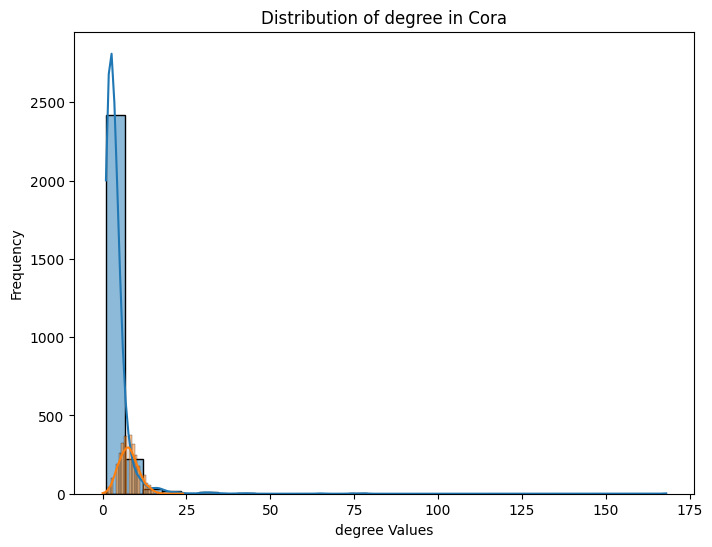

diameter: None
diameter: None


<Figure size 800x600 with 0 Axes>

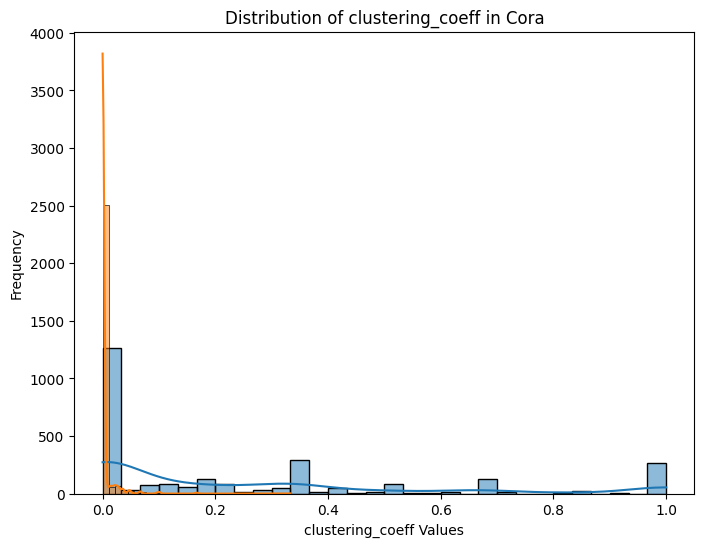

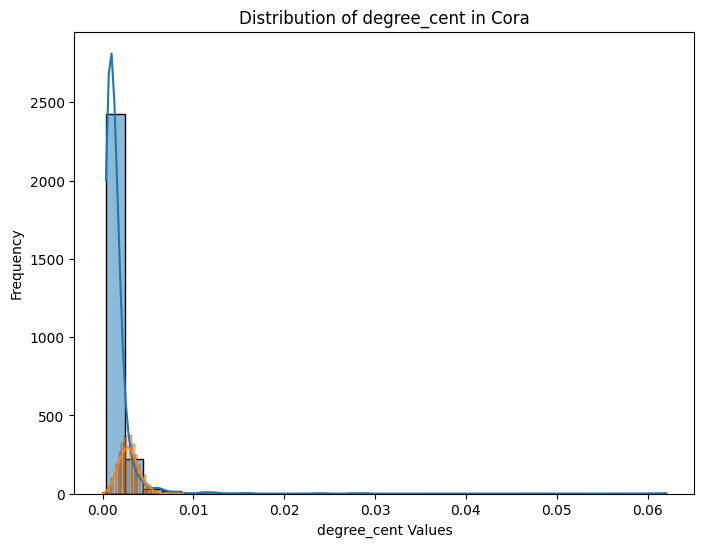

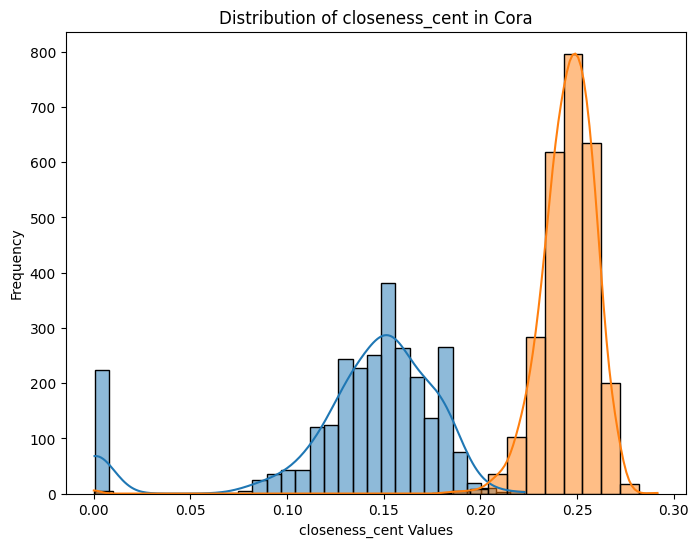

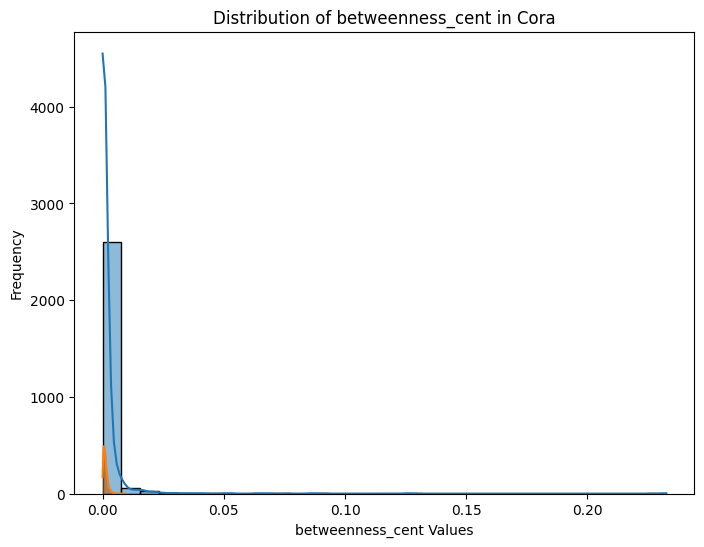

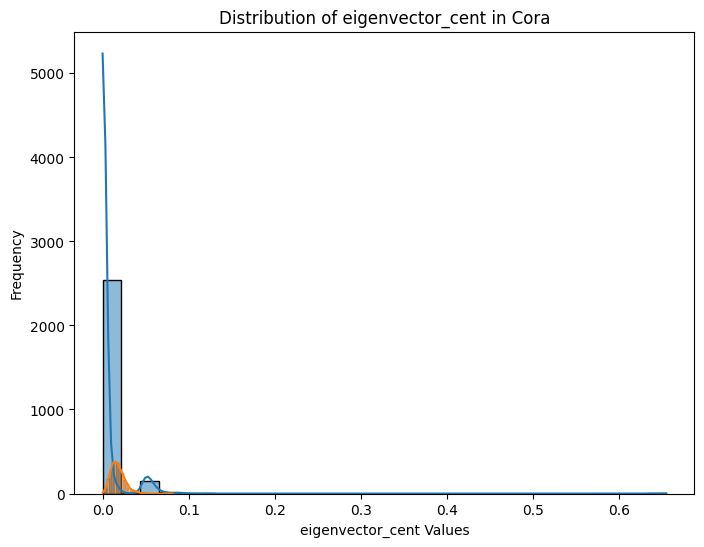

eccentricity: None
eccentricity: None


<Figure size 800x600 with 0 Axes>

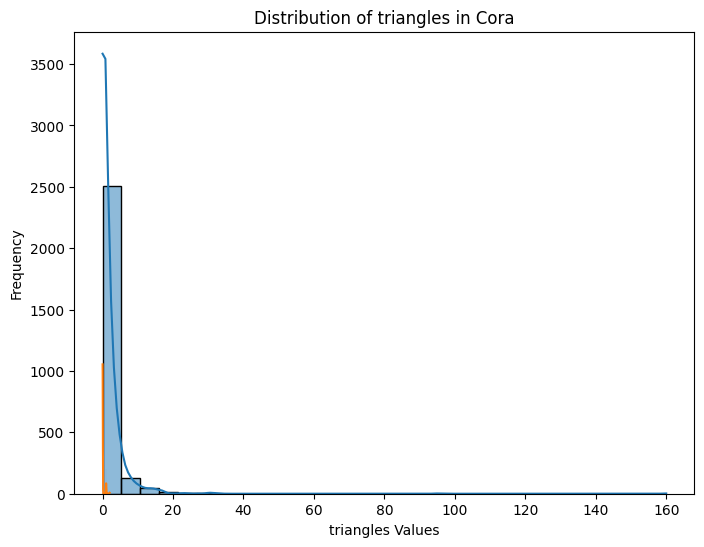

In [ ]:
print("CoraML VS CoraSynthML Metrics Distributions:")
visualize_metrics("Cora", cora_metrics, cora_synth_metrics)